<div style="padding: 30px 60px; border: 5px skyblue solid; border-radius: 30px; max-width: 600px; font-size: 2rem; line-height: 3rem; color: black; font-family: sans-serif;">

  <div style="font-size: 1.5rem; font-weight: 200;">[CM3070] Final Project - BSc CS University of London</div>
  <div style="font-size: 1.5rem; font-weight: 500;">Deep Learning on Satellite Imagery</div>
  <div style="font-size: 2rem; color: dodgerblue; font-weight: bold;">by Arjun Bajaj</div>
</div>

# Establishing a Baseline for the EuroSAT dataset

Since the EuroSAT dataset has 10 classes, the random baseline is `10%`. However, a better baseline can be established using non-deep-learning techniques. In this notebook, a baseline is established using shallow single-layer dense network. This shallow network is akin to logistic regression.

To establish this baseline, each image is subdivided into 4 squares of 32x32px each. The Red, Green, and Blue channels are averaged separately for each square. These values, (`3 channels * 4 squares = 12`) are passed into a single-layer fully-connected network.

The resulting accuracy is significantly higher than the random baseline of `10%`. However, the subsequent notebooks show that `Conv2D` networks are extremely powerful on images, making Deep Learning techniques suitable for classifying satellite imagery.

In [1]:
import numpy as np
import tensorflow as tf
from core import load_eurosat, compile_and_train_model

# Preparing the Dataset

In [2]:
# split an image into 4 tiles, and take the average of each band (RGB)
def process_image(image):
  tile_size = 32
  tiles = []

  for x in range(0, 64, tile_size):
    for y in range(0, 64, tile_size):
      tile = image[x:x+tile_size, y:y+tile_size]
      results = []

      for band in np.split(tile, 3, axis=2):
        results.append(np.average(band))

      tiles.append(np.array(results))

  return np.concatenate(tiles)

In [3]:
# create a dataset of processed images
def create_dataset(ds):
  ds_features = []
  ds_labels = []

  for image, label in ds.unbatch().as_numpy_iterator():
    features = process_image(image)
    ds_features.append(features)
    ds_labels.append(label)

  f = tf.data.Dataset.from_tensor_slices(ds_features)
  l = tf.data.Dataset.from_tensor_slices(ds_labels)

  dataset = tf.data.Dataset.zip((f, l))
  dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)

  return dataset

In [5]:
(train, val, _) = load_eurosat()
train = create_dataset(train)
val = create_dataset(val)
dataset = (train, val, None)

Found 21600 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.


In [6]:
# Shape of the Features Array
train.unbatch().take(1).as_numpy_iterator().next()[0].shape

(12,)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 10)                130       
                                                                 
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
338/338 [==============================] - 2s 5ms/step - loss: 38.8243 - accuracy: 0.0771 - val_loss: 14.9014 - val_accuracy: 0.1044
Epoch 2/30
338/338 [==============================] - 2s 5ms/step - loss: 10.8191 - accuracy: 0.1423 - val_loss: 8.7371 - val_accuracy: 0.1863
Epoch 3/30
338/338 [==============================] - 2s 5ms/step - loss: 7.5321 - accuracy: 0.1933 - val_loss: 6.7770 - val_accuracy: 0.2322
Epoch 4/30
338/338 [==========

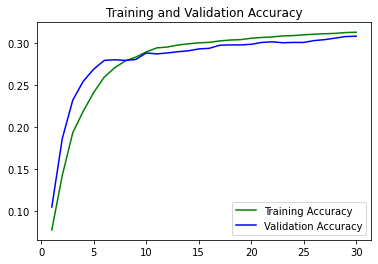

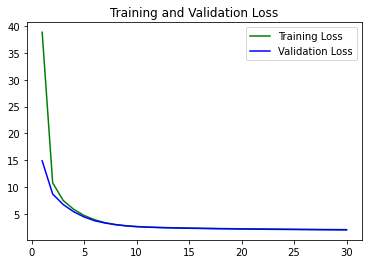

43/43 [==============================] - 0s 4ms/step - loss: 2.0544 - accuracy: 0.3085

Trained for 30 epochs in 0m52s.
Highest Validation Accuracy: 30.85%


In [7]:
# Single-Layer Fully-Connected Model
inputs = tf.keras.Input(shape=(12))
x = tf.keras.layers.Dense(10, activation='softmax')(inputs)
model = tf.keras.Model(inputs, x)
model.summary()

# Train the model for 30 epochs
compile_and_train_model(model, 'baseline.keras', dataset, epochs=30, early_stopping=False)

# Results

The model above achieves an accuracy of `30.85%`. This shows that it is possible to do better than the random baseline of `10%`, however other techniques are required to classify the images with much higher accuracy.

----